In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

/Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 1. Train model

#### 1.1. Describe data and split dataset

In [2]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [3]:
# load dataset
df = describe_dataset("./train.csv")

# Categorizing label
df.loc[df["label"] == "C", "label"] = 0
df.loc[df["label"] == "L", "label"] = 1

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 15372 
Number of columns: 37

Labels: 
C    8238
L    7134
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


In [4]:
sc = StandardScaler()

In [5]:
# applying the standard scalar to the csv file

In [6]:
with open("./model/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

In [7]:
# Standard Scaling of features
x = df.drop("label", axis = 1)
x = pd.DataFrame(sc.transform(x))

y = df["label"].astype('int')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)
y_train.head()

9465     1
8833     0
6190     0
7645     0
13890    1
Name: label, dtype: int64

#### 1.2. Train model using Scikit-learn

In [9]:

from sklearn.ensemble import HistGradientBoostingClassifier
             
algorithms =[("HistGradientBoosting", HistGradientBoostingClassifier()),
             ("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,HistGradientBoosting,"[0.999, 0.999]",0.999350,"[0.999, 0.999]","[0.999, 0.999]","[[1678, 1], [1, 1395]]"
1,RF,"[0.999, 0.999]",0.999024,"[0.999, 0.999]","[0.999, 0.999]","[[1677, 2], [1, 1395]]"
2,KNN,"[0.997, 0.999]",0.998049,"[0.999, 0.996]","[0.998, 0.998]","[[1678, 1], [5, 1391]]"
3,SVC,"[0.997, 0.995]",0.996098,"[0.996, 0.996]","[0.996, 0.996]","[[1672, 7], [5, 1391]]"
4,DTC,"[0.998, 0.991]",0.995122,"[0.993, 0.998]","[0.996, 0.995]","[[1667, 12], [3, 1393]]"
5,SGDC,"[0.986, 0.979]",0.982439,"[0.982, 0.983]","[0.984, 0.981]","[[1649, 30], [24, 1372]]"
6,LR,"[0.986, 0.975]",0.980813,"[0.979, 0.983]","[0.982, 0.979]","[[1644, 35], [24, 1372]]"
7,NB,"[0.927, 0.842]",0.884878,"[0.857, 0.918]","[0.89, 0.879]","[[1439, 240], [114, 1282]]"


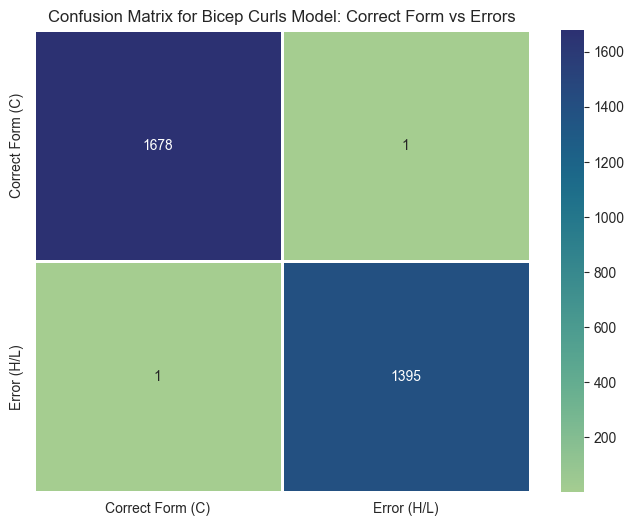

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the confusion matrix for HistGradientBoosting from final_results
bicep_cm = next(item[5] for item in final_results if item[0] == "HistGradientBoosting")

# Create a DataFrame for the confusion matrix with appropriate labels
cm_df = pd.DataFrame(bicep_cm, 
                     index=["Correct Form (C)", "Error (H/L)"], 
                     columns=["Correct Form (C)", "Error (H/L)"])

# Plot the confusion matrix heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="crest", linewidths=1, ax=ax)

# Add title
ax.set_title("Confusion Matrix for Bicep Curls Model: Correct Form vs Errors")

# Display the plot
plt.show()


#### 1.3. Dump models pickle

In [14]:
# sklearn is just used to see whether the classification can be done easily by simple model or not. 
# Instead of using the LSTM if the classification is done by simpler model, than we can directly use the simple model. 

In [16]:
with open("./model/all_sklearn_jainil.pkl", "wb") as f:
    pickle.dump(models, f)

In [13]:
with open("./model/input_scaler_jainil.pkl", "wb") as f:
    pickle.dump(sc, f)